In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Concrete Compressive Strength Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete.data.features 
y = concrete.data.targets 

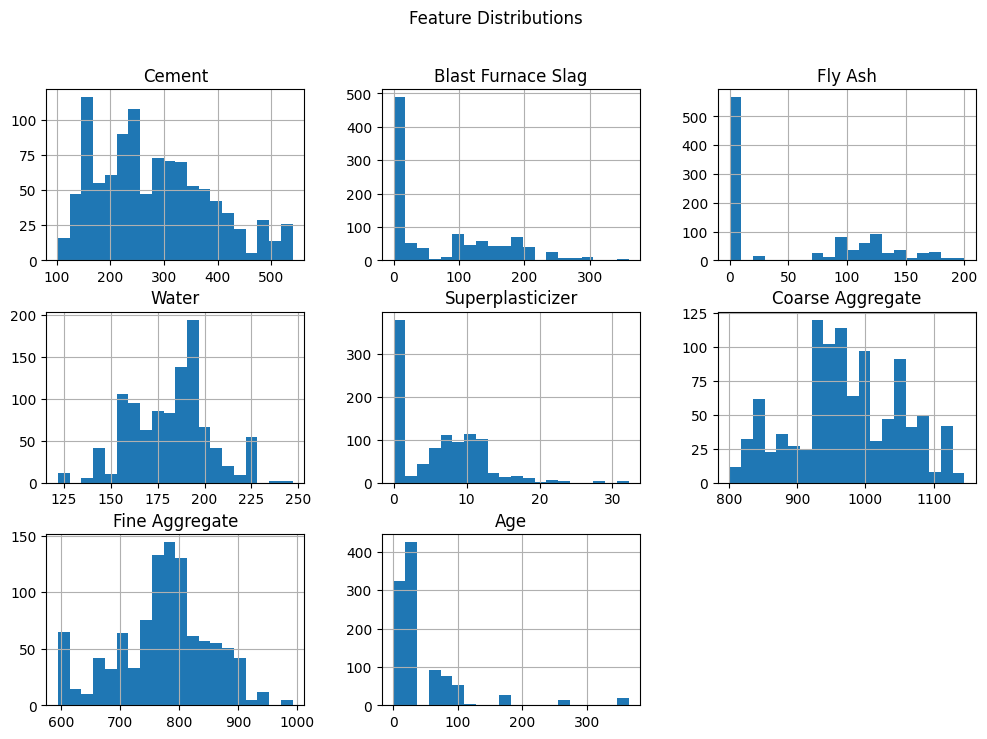

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

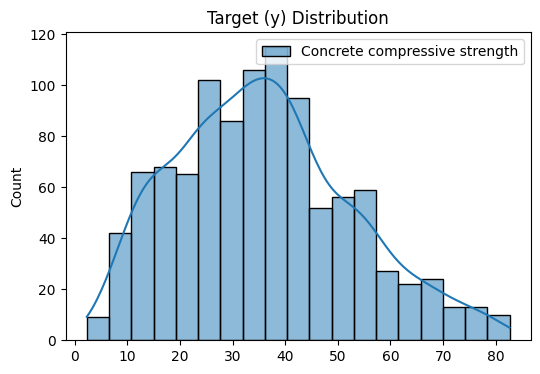

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

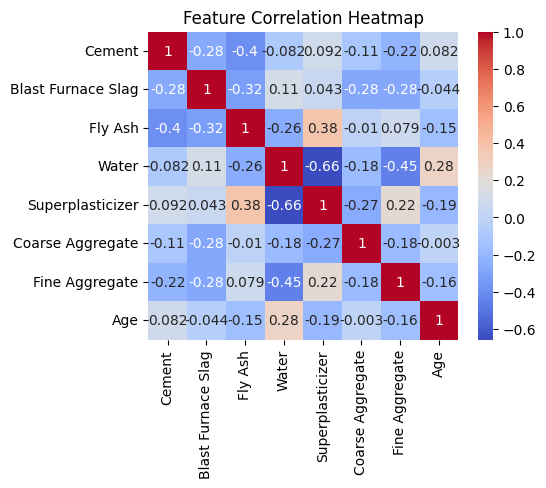

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.076782                 1.182986             1.187261   
1                  1.104782                 1.273097             1.373301   
2                  1.285257                 1.232368             1.333300   
3                  1.108553                 1.220600             1.356698   
4                  1.124015                 1.289979             1.172891   
5                  1.095545                 1.316963             1.285269   
6                  1.132766                 1.378772             1.478036   
7                  1.169513                 1.319938             1.131421   
8                  1.301059                 1.786530             1.872994   
9                  1.245964                 1.331608             1.505958   
mean               1.164423                 1.333284             1.369713   
std                0.082787              

In [8]:
rhat_df.to_csv("results/real4_Concrete_rhat.csv", index=False)

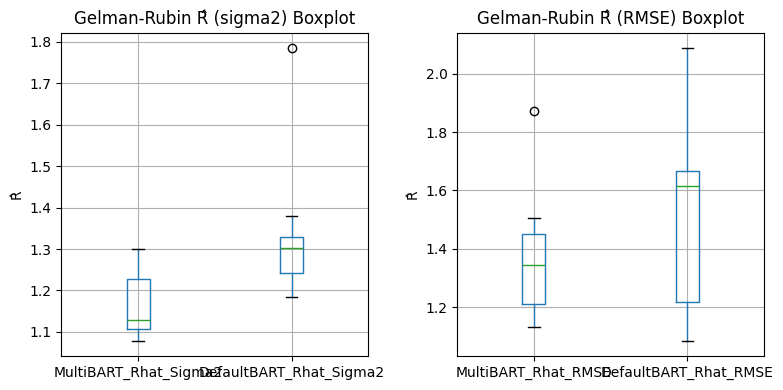

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

test_mse:
      bart_mtmh       bart        btz         rf        xgb
0     16.437303  20.138241  21.362145  25.337002  22.455559
1     20.248487  25.436171  27.050854  28.011630  22.121190
2     16.083834  22.857502  23.918587  22.319608  20.070588
3     18.900074  17.011405  19.248110  24.326422  20.167277
4     15.901046  17.850026  17.904802  24.962981  20.543163
5     18.986083  19.931444  18.519383  26.308469  19.923279
6     16.019059  19.641556  19.867299  25.070558  20.328900
7     13.058087  19.463639  17.063320  21.417550  14.329891
8     18.644551  22.458857  20.727949  31.274851  32.522720
9     16.323322  17.465186  18.529009  25.410759  25.434845
mean  17.060184  20.225403  20.419146  25.443983  21.789741
std    2.110774   2.659877   3.048703   2.767778   4.683846



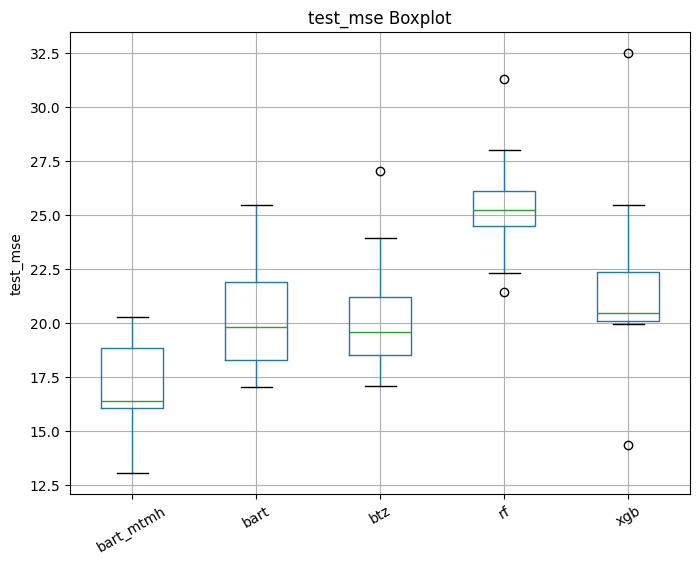

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      4.644936  7.630388  8.901965  4.507947  1.485153
1      4.634265  7.595982  7.525078  4.546035  1.495007
2      4.593678  7.352345  7.956736  4.560098  1.395256
3      3.811820  6.373595  8.305401  4.021529  1.089786
4      4.985629  7.779412  8.548061  4.354594  1.349169
5      4.237925  7.592527  8.465735  4.597305  1.337065
6      4.264087  8.217775  8.032753  4.637098  1.315198
7      4.717887  7.645805  9.538532  4.734191  1.460623
8      2.980257  5.786281  7.011750  3.413750  0.405178
9      3.651582  6.720142  7.768730  3.984985  0.462414
mean   4.252207  7.269425  8.205474  4.335753  1.179485
std    0.609596  0.741864  0.717062  0.410202  0.409934



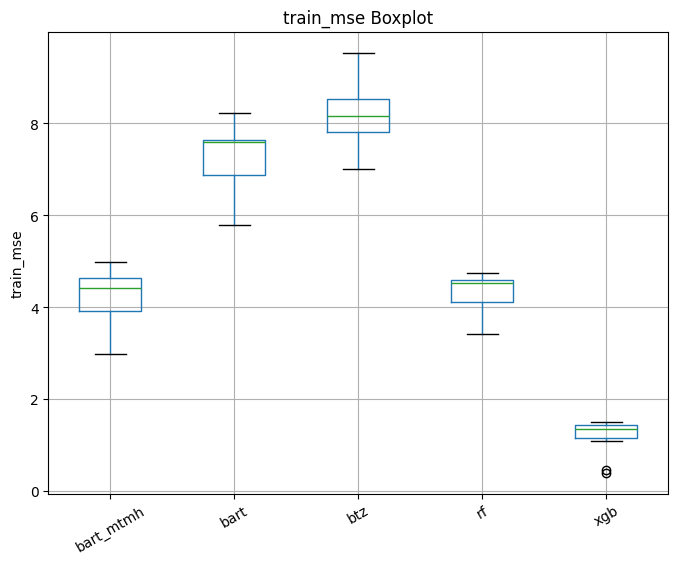

pi_length:
      bart_mtmh       bart        btz
0     13.793421  14.759235  16.856497
1     14.372236  14.375235  16.071192
2     14.219580  14.883156  16.627243
3     12.605829  13.540787  16.433155
4     14.267369  14.552045  16.573692
5     13.661709  14.533428  16.306211
6     13.517915  15.248567  16.613911
7     14.093561  14.594890  17.238094
8     11.952376  12.998259  16.588951
9     12.555844  13.557459  16.103432
mean  13.503984  14.304306  16.541239
std    0.844478   0.705809   0.346497



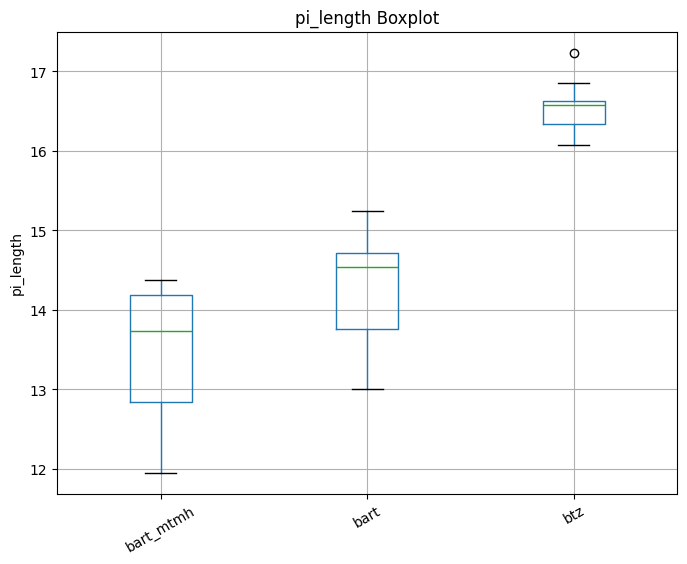

coverage:
      bart_mtmh      bart       btz
0      0.937984  0.918605  0.945736
1      0.930233  0.883721  0.899225
2      0.930233  0.930233  0.949612
3      0.914729  0.918605  0.941860
4      0.957364  0.941860  0.953488
5      0.914729  0.926357  0.937984
6      0.903101  0.906977  0.934109
7      0.957364  0.918605  0.961240
8      0.899225  0.887597  0.937984
9      0.914729  0.906977  0.930233
mean   0.925969  0.913953  0.939147
std    0.020465  0.018162  0.016850



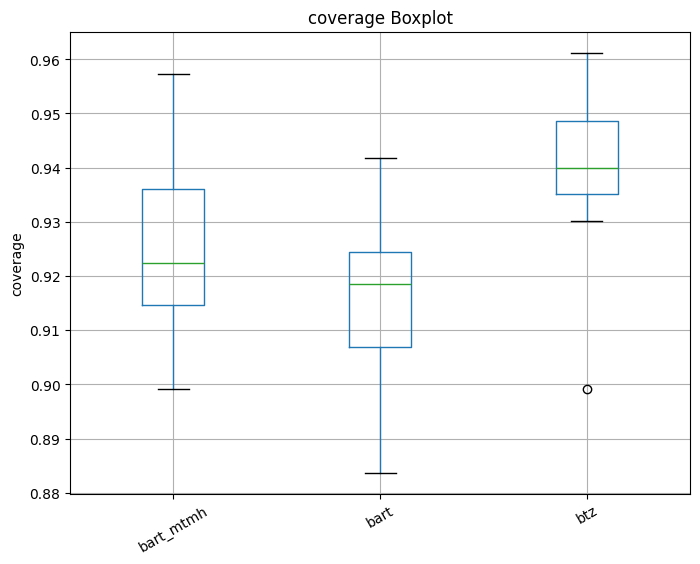

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     135.632860  24.469791  59.826154  5.086213  2.004928
1     136.292319  24.492076  74.389934  0.647269  0.334262
2     134.763218  24.252650  55.792071  4.821292  2.674750
3     134.966512  24.462431  56.635828  5.550705  1.583262
4     135.741103  24.250041  59.854402  5.100741  1.705009
5     136.622067  24.629713  75.055486  0.581092  0.493257
6     136.178288  24.248393  68.033971  2.564244  0.562505
7     135.593885  24.470289  62.115051  4.684598  0.993151
8     136.514021  24.726799  75.026972  0.589156  0.460899
9     136.232961  24.985450  76.919408  0.543460  0.377955
mean  135.853724  24.498763  66.364928  3.016877  1.118998
std     0.630097   0.234319   8.424732  2.232257  0.821875



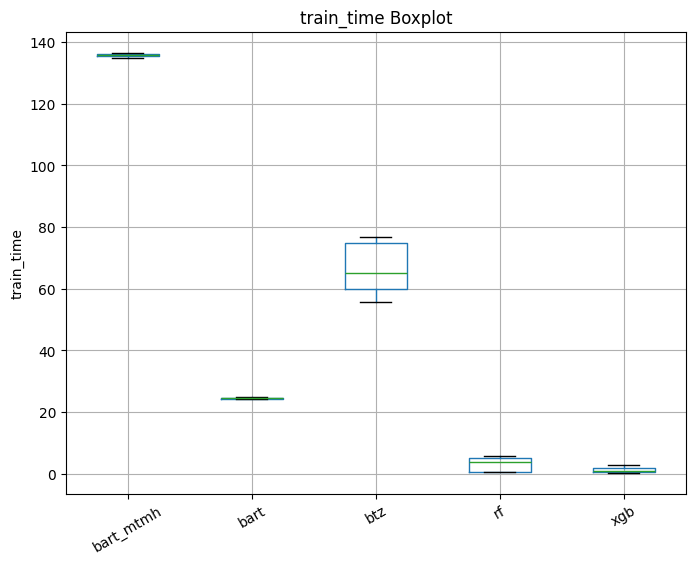

In [10]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=-2)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [11]:
for k, v in mse_results.items():
    csv_name = f"results/real4_Concrete_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [ ]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real4_Concrete_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=10, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=-2
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real4_Concrete_tries.csv", index=False)

In [ ]:
print(df)